In [75]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import json
import os
import sys

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vvc import config
from vvc.detector import detector

In [77]:
dataset_folder = config.video_folder

model_name = 'frcnn-resnet50'

experiment_folder = os.path.join(config.base_folder, 'Videos', 'vvc')

video_name = 'CL 53 X CRA 60 910-911'

file_extension = '.mp4.json'

test_file = os.path.join(dataset_folder, 'cvat', video_name + '.xml')
experiment_file = os.path.join(experiment_folder, video_name, model_name + file_extension)

experiment_file

'/home/juan/workspace/Maestria/Videos/vvc/CL 53 X CRA 60 910-911/frcnn-resnet50.mp4.json'

In [78]:
def vott_to_dataframe(json_file):
    test_annotations = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)

        for frame_id, boxes in data['frames'].items():
            if not frame_id in test_annotations:
                test_annotations[frame_id] = {}
            for box in boxes:
                for tag in box['tags']:
                    if not tag in test_annotations[frame_id]:
                        test_annotations[frame_id][tag] = 0
                    test_annotations[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.drop(columns=['ignore'])
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df
    
#test = vott_to_dataframe(test_file)
#test.iloc[4:].head()

In [79]:
import xml.etree.ElementTree as ET


def counts_cvat_to_df(in_file):
    '''
    
    '''
    test_annotations = {}
    df = pd.DataFrame()
    
    tree=ET.parse(in_file)
    annotations = tree.getroot()
    
    for track in annotations.iter('track'):
        if track.attrib['label'] == 'vehicle':
            for box in track:
                frame_id = box.get('frame')
                if not frame_id in test_annotations:
                    test_annotations[frame_id] = {}
                    v_type = None
                    lr_side = None
                    fb_side = None
                for attribute in box:
                    if attribute.get('name') == 'type':
                        v_type = attribute.text
                    elif attribute.get('name') == 'LR_side':
                        lr_side = attribute.text
                    elif attribute.get('name') == 'FB_side':
                        fb_side = attribute.text if attribute.text != '__undefined__' else 'back'
                tag = v_type #+ '_' + fb_side + '_' + lr_side
                
                if not tag in test_annotations[frame_id]:
                    test_annotations[frame_id][tag] = 0
                test_annotations[frame_id][tag] += 1
                    

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df

test = counts_cvat_to_df(test_file)
test.iloc[100:].head()


,motorbike,bus,truck,car
100,1.0,1.0,0.0,0.0
101,1.0,1.0,0.0,0.0
102,1.0,1.0,0.0,0.0
103,1.0,1.0,1.0,0.0
104,1.0,1.0,1.0,0.0


In [80]:
def vvc_to_df(json_file):
    count_summary = {}
    time_summary = {}

    df = pd.DataFrame()
    
    times = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)
        for frame_id, objects in data['frames'].items():
            
            # Extract counts
            if not frame_id in count_summary:
                count_summary[frame_id] = {}
            
            for obj in objects['objects']:
                tag = obj['tag']
                
                if not tag in count_summary[frame_id]:
                    count_summary[frame_id][tag] = 0
                
                count_summary[frame_id][tag] += 1
                
            # Extract running time
            if not frame_id in time_summary:
                time_summary[frame_id] = {}
                
            for key, value in objects['timestamps'].items():
                time_summary[frame_id][key] = value

    df = pd.DataFrame.from_dict(count_summary, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    df = df.reindex(sorted(df.columns), axis=1)
    
    exp = pd.DataFrame()
    
    # Set the values for each perspective
    for column in df.columns:
        for fb_side in ['front', 'back']:
            for lr_side in ['left', 'right']:
                tag = column #+ '_' + fb_side + '_' + lr_side
                exp[tag] = df[column]
    
    exp = exp.sort_index(kind='mergesort')
            
    times = pd.DataFrame.from_dict(time_summary, orient='index')
    times['total'] = times.sum(axis=1)
    
    return exp, times
    
experiment, times = vvc_to_df(experiment_file)

times.iloc[:].head()

,detection,postprocessing,preprocessing,read,tracking,total
0,2712.653,106.209,58.477,44.950,0.031,2922.320
1,1750.702,7.440,4.394,1.660,0.091,1764.287
10,1790.498,8.128,5.090,4.090,0.168,1807.974
100,1733.524,4.934,4.110,2.238,0.092,1744.898
1000,1907.943,5.910,5.759,2.004,0.087,1921.703


In [81]:
def calc_precision(test, experiment): 
    
    # Combine using function    
    min_combined = test.combine(experiment, np.minimum, fill_value=0)
        
    exp_combined = test.combine(experiment, lambda s1, s2: s2, fill_value=0)
    
    equal_combined = test.combine(experiment, np.equal, fill_value=False)
    
            
    precision = min_combined.div(exp_combined)
    
    precision[equal_combined == True] = 1

    precision = precision.fillna(0)
    
    
    precision.sort_index(inplace=True, kind='mergesort')

    return precision

def calc_recall(test, experiment): 
    
    # Combine using function    
    min_combined = test.combine(experiment, np.minimum, fill_value=0)
        
    test_combined = test.combine(experiment, lambda s1, s2: s1, fill_value=0)
    
    equal_combined = test.combine(experiment, np.equal, fill_value=False)
    
            
    recall = min_combined.div(test_combined)
    
    recall[equal_combined == True] = 1

    recall = recall.fillna(0)
    
    
    recall.sort_index(inplace=True, kind='mergesort')

    return precision

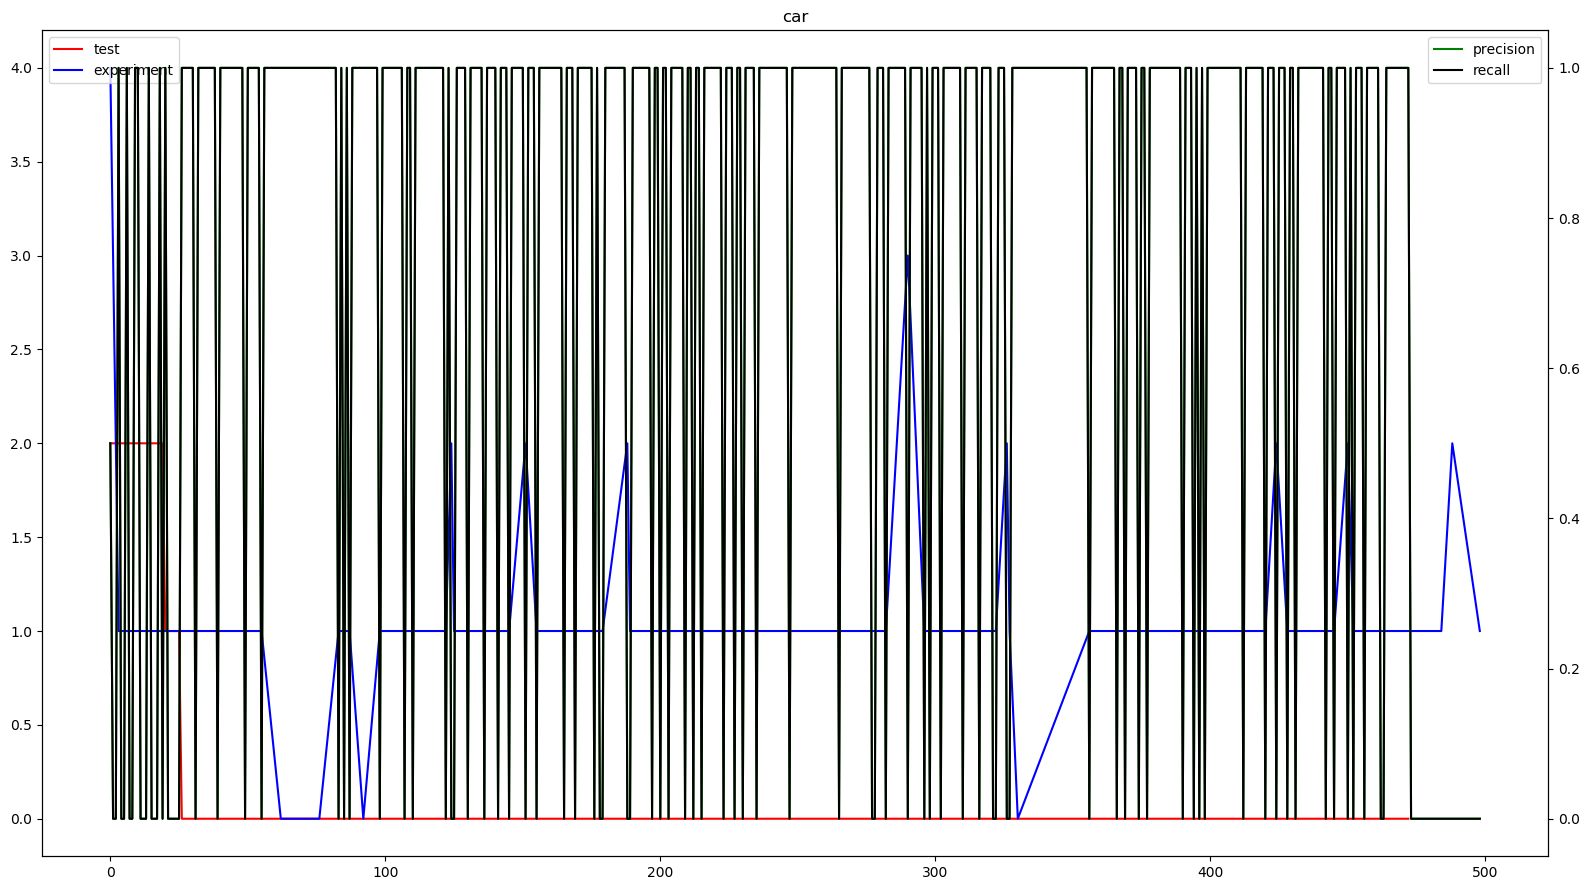

In [82]:
precision = calc_precision(test, experiment)

recall = calc_recall(test, experiment)

def plot_precision(vehicle='car', max_index=500):

    sub_test = test.loc[test.index <= max_index, vehicle]
    sub_predicted = experiment.loc[experiment.index <= max_index, vehicle]
    sub_precision = precision.loc[precision.index <= max_index, vehicle]
    sub_recall = recall.loc[recall.index <= max_index, vehicle]

    fig, ax = plt.subplots(figsize=(16, 9))

    plt.title(vehicle)

    ax.plot(sub_test.index, sub_test, label='test', color='r')

    ax.plot(sub_predicted.index, sub_predicted, label='experiment', color='b')
    
    ax.legend(loc='upper left')

    
    ax2 = ax.twinx()

    ax2.plot(sub_precision.index, sub_precision, label='precision', color='g')

    ax2.plot(sub_recall.index, sub_recall, label='recall', color='k')

    ax2.legend()

    plt.tight_layout()

    
plot_precision()

In [83]:
def compare_models(test_df, models):

    avg_precision = pd.DataFrame(index=test.columns)
    avg_p = pd.DataFrame(columns=models)

    avg_fps = pd.DataFrame(index=['1066x600' ])
    avg_time = pd.DataFrame(index=['preprocessing', 'detection', 'tracking', 'postprocessing'])

    for model in models:
        print('model: ', model)
        experiment_folder = os.path.join(config.base_folder, 'Videos', 'vvc', video_name)
        experiment_file = os.path.join(experiment_folder, model + '.mp4.json')

        experiment, times = vvc_to_df(experiment_file)

        precision = calc_precision(test, experiment)

        mean_precision = precision.mean().to_frame(model)

        avg_precision = avg_precision.join(mean_precision)

        avg_p.loc['avg_p', model] = precision.melt().mean()['value']

        # times

        mean_time = times[avg_time.index].mean().to_frame(model)

        avg_time = avg_time.join(mean_time)

        # fps

        total = times['total']

        fps = (total.count() / total.sum()) * 1000

        avg_fps[model] = fps

        avg_p.loc['balance', model] = avg_p.loc['avg_p', model] * fps
        
    return avg_precision, avg_time, avg_fps, avg_p

# dispay
test = counts_cvat_to_df(test_file)
models = detector.basic_models

avg_precision, avg_time, avg_fps, avg_p = compare_models(test, models)

display(avg_precision)

display(avg_time)

avg_fps

model:  frcnn-resnet50
model:  frcnn-resnet50-transfer
model:  YOLOv3
model:  YOLOv3-transfer
model:  YOLOv3-tiny
model:  YOLOv3-tiny-transfer
model:  RetinaNet-ResNet50


,frcnn-resnet50,frcnn-resnet50-transfer,YOLOv3,YOLOv3-transfer,YOLOv3-tiny,YOLOv3-tiny-transfer,RetinaNet-ResNet50
motorbike,0.452802,0.267191,0.419062,0.255446,0.380399,0.211416,0.482663
bus,0.774336,0.721022,0.779123,0.718812,0.757475,0.699789,0.776006
truck,0.629794,0.506876,0.590015,0.502970,0.579734,0.469345,0.584605
car,0.581858,0.874263,0.666090,0.889109,0.704319,0.945032,0.620280


,frcnn-resnet50,frcnn-resnet50-transfer,YOLOv3,YOLOv3-transfer,YOLOv3-tiny,YOLOv3-tiny-transfer,RetinaNet-ResNet50
preprocessing,6.247902,6.211502,3.882512,3.511151,3.531935,3.571002,3.436280
detection,1796.337506,1818.979921,215.528736,210.723387,42.838008,40.723006,1048.842085
tracking,0.107213,0.026865,0.382823,0.015298,0.093594,0.014914,0.088651
postprocessing,5.154428,5.216908,4.088511,3.367600,3.532443,3.133974,3.895781


,frcnn-resnet50,frcnn-resnet50-transfer,YOLOv3,YOLOv3-transfer,YOLOv3-tiny,YOLOv3-tiny-transfer,RetinaNet-ResNet50
1066x600,0.55235,0.54556,4.422791,4.553549,19.223711,18.881458,0.945087


In [84]:
display(avg_p)

best_precision_model = avg_p.sort_values(by ='avg_p', axis=1, ascending=False).columns[0]

print('best precision model: ', best_precision_model)

best_balance_model = avg_p.sort_values(by ='balance', axis=1, ascending=False).columns[0]

print('best balance model: ', best_balance_model)

,frcnn-resnet50,frcnn-resnet50-transfer,YOLOv3,YOLOv3-transfer,YOLOv3-tiny,YOLOv3-tiny-transfer,RetinaNet-ResNet50
avg_p,0.609698,0.592338,0.689648,0.591584,0.605482,0.581395,0.690214
balance,0.336767,0.323156,3.05017,2.69381,11.6396,10.9776,0.652312


best precision model:  RetinaNet-ResNet50
best balance model:  YOLOv3-tiny


<Figure size 640x480 with 0 Axes>

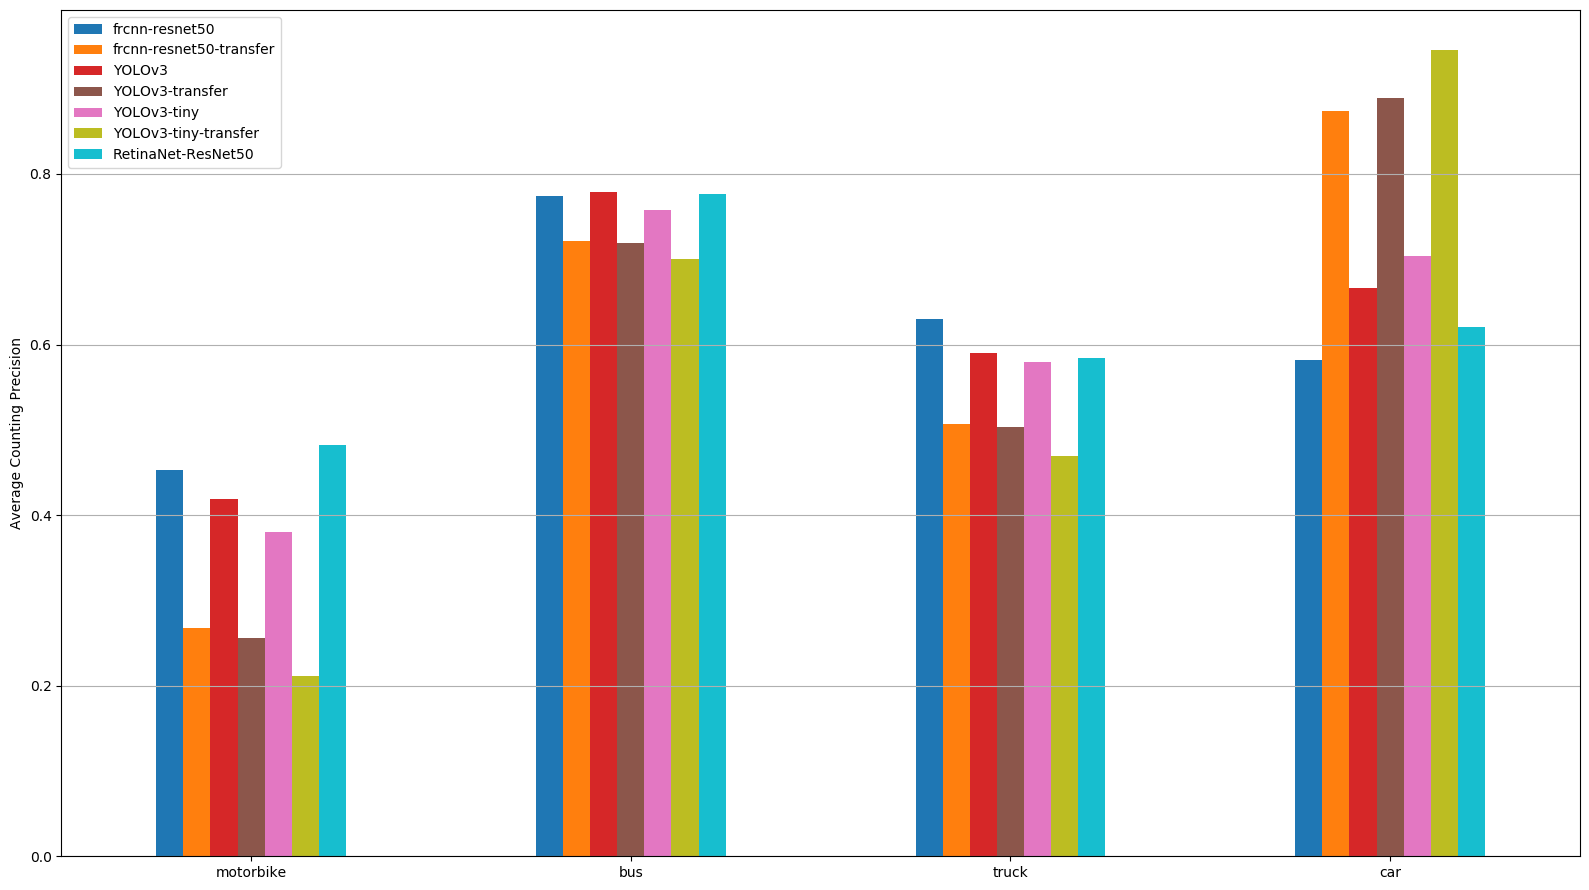

In [85]:
def plot_avg_precision(avg_precision, prefix='basic', cmap=plt.cm.tab10):
    plt.figure()

    ax = avg_precision.plot.bar(figsize=(16, 9), rot=0, cmap=cmap)

    plt.grid(axis='y')

    ax.set_ylabel('Average Counting Precision')

    plt.tight_layout()

    fig = ax.get_figure()
    fig.savefig('./img/{}_avg_precision.png'.format(prefix))
    #fig.savefig('./img/{}avg_precision.tif', dpi=300)

    
mpl.style.use('default')
plot_avg_precision(avg_precision)

<Figure size 640x480 with 0 Axes>

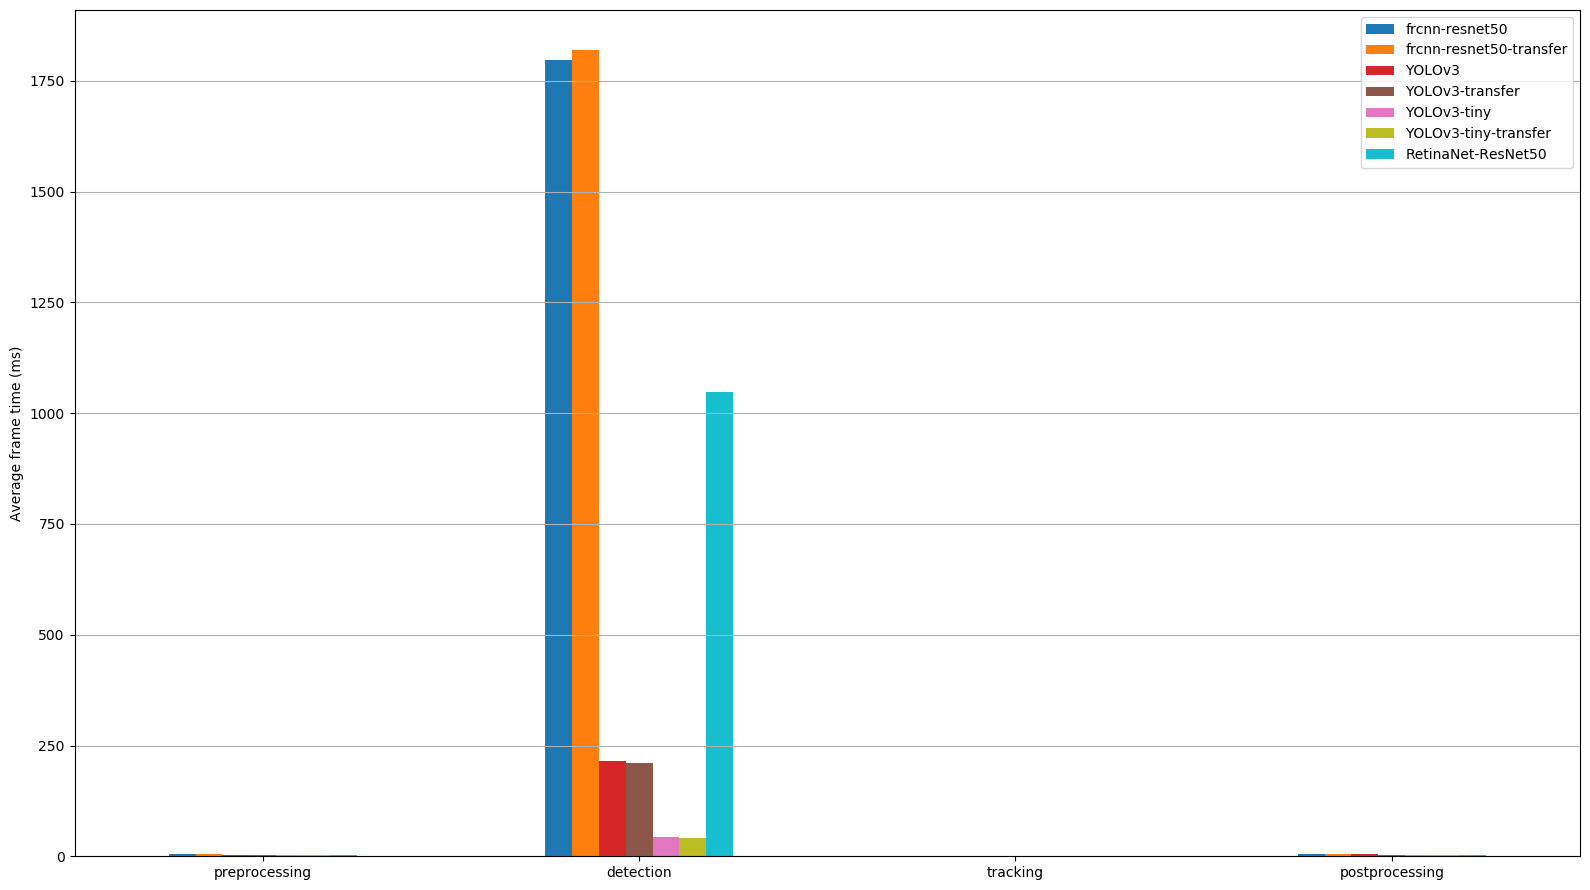

In [86]:
def plot_avg_time(avg_time, prefix='basic', cmap=plt.cm.tab10):
    plt.figure()

    ax = avg_time.plot.bar(figsize=(16, 9), rot=0, cmap=cmap)

    plt.grid(axis='y')

    ax.set_ylabel('Average frame time (ms)')

    plt.tight_layout()

    fig = ax.get_figure()
    fig.savefig('./img/{}_avg_time.png'.format(prefix))

plot_avg_time(avg_time)

<Figure size 640x480 with 0 Axes>

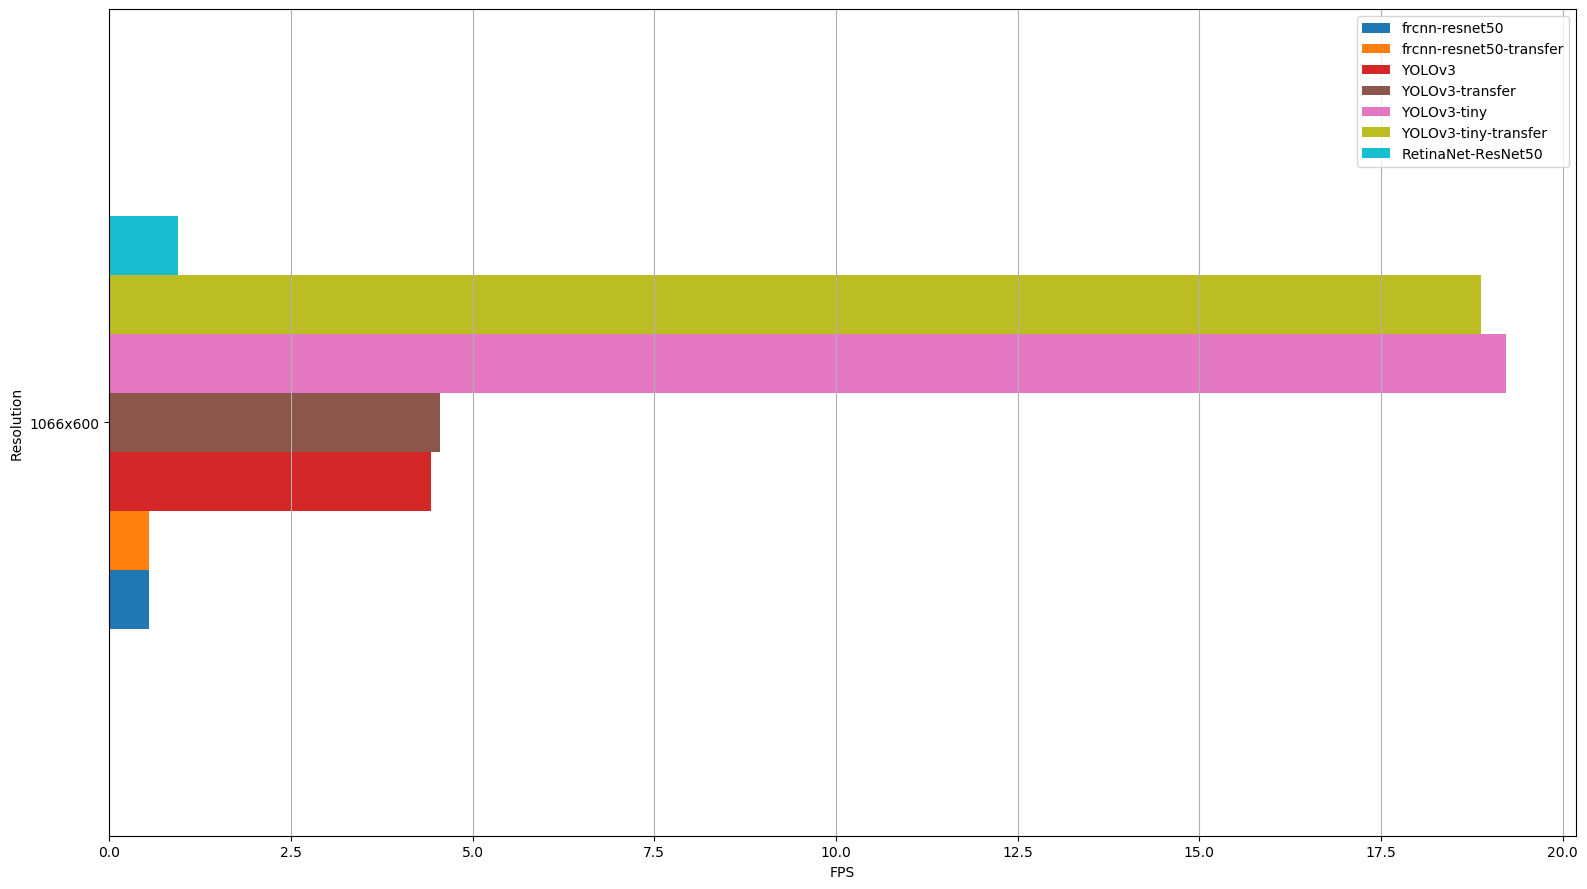

In [87]:
def plot_avg_fps(avg_fps, prefix='basic', cmap=plt.cm.tab10):
    plt.figure()

    ax = avg_fps.plot.barh(figsize=(16, 9), cmap=cmap)

    plt.grid(axis='x')

    ax.set_ylabel('Resolution')
    ax.set_xlabel('FPS')

    plt.tight_layout()

    fig = ax.get_figure()
    fig.savefig('./img/{}_avg_fps.png'.format(prefix), dpi=300)
    
plot_avg_fps(avg_fps)

model:  RetinaNet-ResNet50
model:  YOLOv3-tiny
model:  vvc1-yolov3
model:  vvc2-yolov3
model:  vvc3-yolov3


<Figure size 640x480 with 0 Axes>

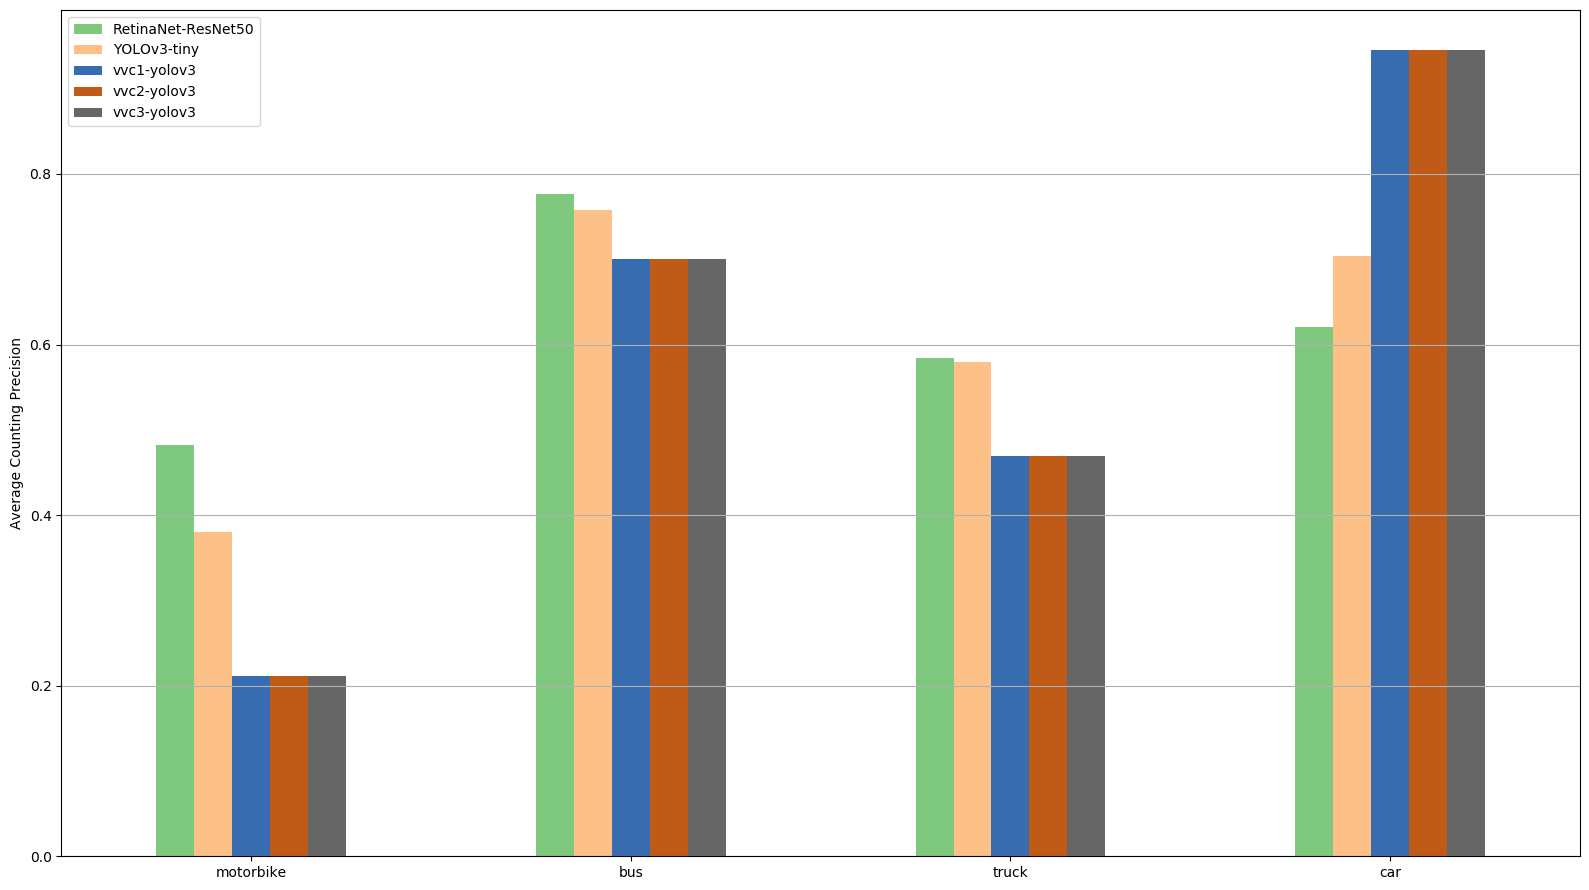

<Figure size 640x480 with 0 Axes>

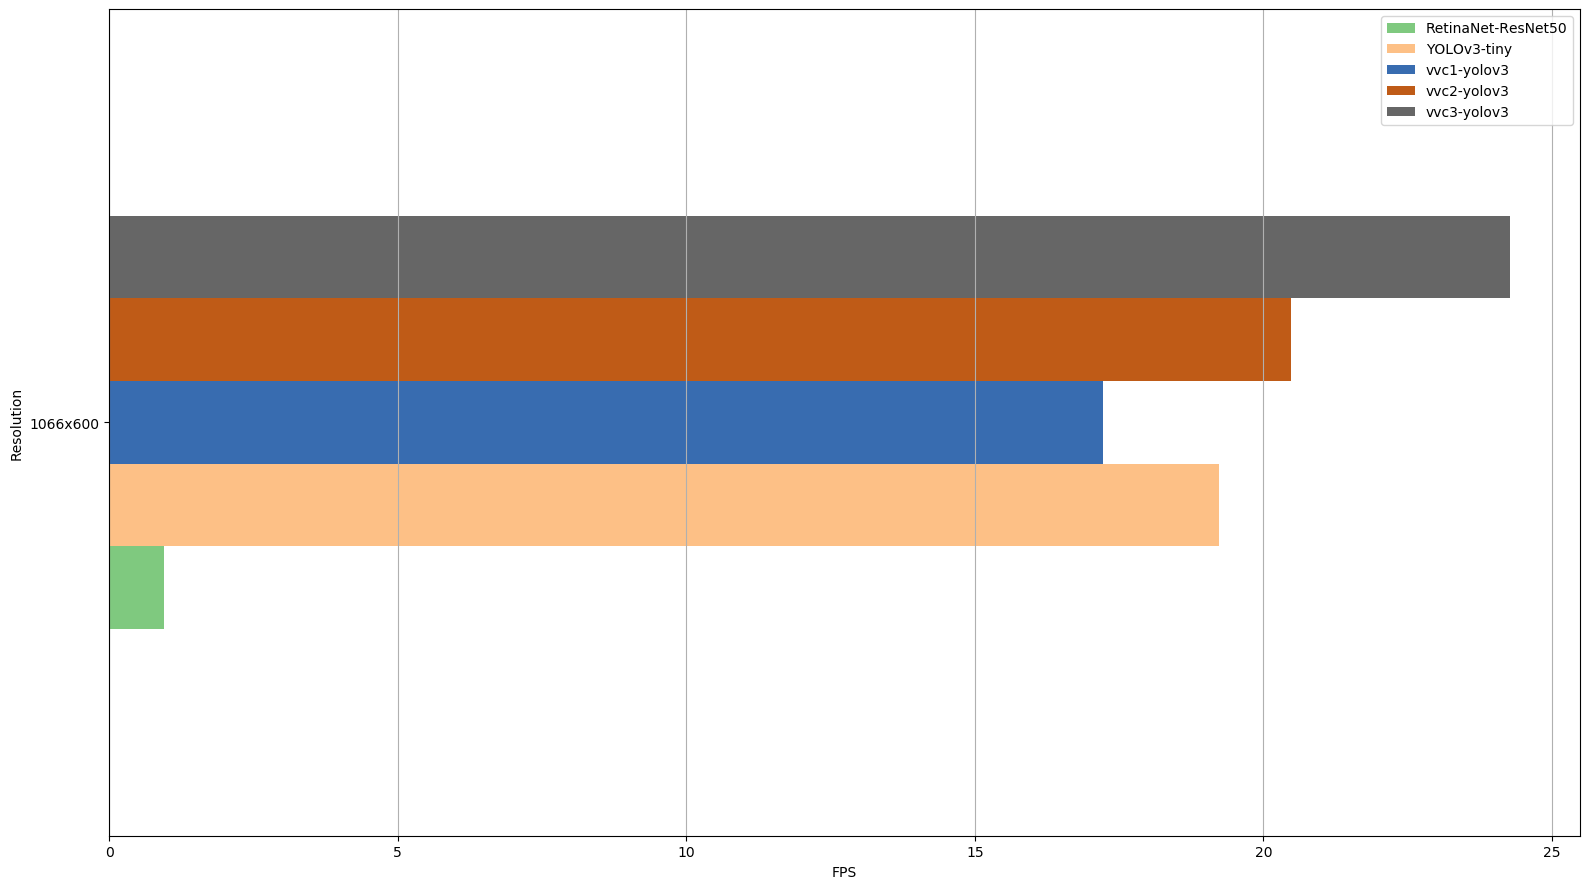

In [95]:
import matplotlib as mpl

custom_models = [best_precision_model, best_balance_model] + detector.vvc_models 

avg_precision, avg_time, avg_fps, avg_p = compare_models(test, custom_models)

prefix = 'custom'

cmap = plt.cm.Accent

plot_avg_precision(avg_precision, prefix, cmap)
#plot_avg_time(avg_time, prefix)
plot_avg_fps(avg_fps, prefix, cmap)